In [507]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict
class Nodo:
      GuiaT_N :Dict[int, 'Nodo'] = {}
      GuiaTT_D :Dict[tuple, int] = {}
      GuiaP_N :Dict[tuple, 'Nodo'] = {} 
      def __init__(self, posicion: tuple):
            self.DISTANCIA_MINIMA = 3
            self.tag = len(Nodo.GuiaT_N)
            Nodo.GuiaT_N[self.tag] = self
            Nodo.GuiaP_N[posicion] = self
            self.vecinos = []
            self.posicion = posicion
      def AgregarVecino(self, vecino: 'Nodo', distancia: int = None):
            vecino = Nodo.GuiaP_N.get(vecino, None)
            if vecino != None:
                  self.vecinos.append(vecino)
                  vecino.vecinos.append(self)
                  dis = self.DISTANCIA_MINIMA + np.random.randint(5)
                  Nodo.GuiaTT_D[(self.tag, vecino.tag)] = distancia if distancia != None else dis
                  Nodo.GuiaTT_D[(vecino.tag, self.tag)] = distancia if distancia != None else dis
class Pasajero:
      tag_count = 0
      def __init__(self, tag_inicio = None, tag_final = None) -> None:
            self.tag = Pasajero.tag_count
            Pasajero.tag_count += 1
            lstPT = list(Nodo.GuiaT_N.keys()).copy()
            if tag_inicio == None:
                  k = np.random.randint(len(lstPT))
                  self.Tag_inicio = lstPT[k]
                  lstPT.pop(k)
            else:
                  self.Tag_inicio = tag_inicio
                  
            if tag_final == None:
                  k = np.random.randint(len(lstPT))
                  self.Tag_final = lstPT[k]
            else:
                  self.Tag_final = tag_final
            
      def ReiniciarTags():
            Pasajero.tag_count = 0
            
      def toStr(self):
            return f"{self.tag} : {self.Tag_inicio} -> {self.Tag_final}"
      
class Ruta:
      def __init__(self, distancia = 0, n_tags = [], fijo = False) -> None:
            self.distancia = distancia
            self.n_tags = n_tags
            self.fijo = fijo

class Ciudad:

      def __init__(self, lado: int, n_pasajeros: int) -> None:
            self.Lado = lado
            #Se define una ciudad cuadriculada
            self.Nodos = np.array([[Nodo((i,j)) for i in range(lado)] for j in range(lado)], dtype=Nodo)
            for i in range(lado):
                  for j in range(lado):
                        nposicion = (i,j)
                        nodo_ini = Nodo.GuiaP_N[nposicion]
                        nodo_ini.AgregarVecino((i + 1, j))
                        nodo_ini.AgregarVecino((i, j + 1))
            #DefinirPasajeros
            self.pasajeros = [Pasajero() for i in range(n_pasajeros)]
            self.Mdistancias : Dict[int,Dict[int:Ruta]]= self.GenerarMatrizDistancias()
            
      def MostrarPasajeros(self):
            print(f"Hay {len(self.pasajeros)} pasajeros")
            for p in self.pasajeros:
                  print(p.toStr())
                  
      def GenerarMatrizDistancias(self):
            Distancias = {}        
            NNodos = len(Nodo.GuiaT_N)
            for i in range(self.Lado):
                  for j in range(self.Lado):
                        n_origen :Nodo = Nodo.GuiaP_N[(i,j)]
                        dic_rutas = {n_origen.tag : Ruta(distancia= 0, n_tags= [n_origen.tag], fijo= True)} #El primero nodo se agrega a si mismo como nodo fijo
                        rutas_fijas = [r for r in dic_rutas.values() if r.fijo]
                        
                        while(len(rutas_fijas) != NNodos):
                              #Para todo vecino de cada nodo fijo agregarlo al diccionario de rutas o una version menos pesada
                              #print("Fijos :",[r.n_tags for r in rutas_fijas])
                              for ruta in rutas_fijas:
                                    nodo_final_ruta = Nodo.GuiaT_N[ruta.n_tags[-1]]
                                    for nodo_vecino in nodo_final_ruta.vecinos:
                                          d = Nodo.GuiaTT_D[(nodo_final_ruta.tag, nodo_vecino.tag)] + ruta.distancia
                                          if (nodo_vecino.tag not in dic_rutas.keys() or d < dic_rutas[nodo_vecino.tag].distancia):
                                                nr_n_tags = ruta.n_tags.copy()
                                                nr_n_tags.append(nodo_vecino.tag)
                                                dic_rutas[nodo_vecino.tag] = Ruta(distancia = d,n_tags = nr_n_tags)
                              
                              rnfs = [r for r in dic_rutas.values() if not r.fijo]
                              #print("No fijo :",[r.n_tags for r in rnfs])
                              rnfs.sort(key=lambda r: r.distancia)
                              rnfs[0].fijo = True
                                    
                              rutas_fijas = [r for r in dic_rutas.values() if r.fijo]
                        Distancias[n_origen.tag] = dic_rutas
                              
            return Distancias
      def getPasajerosTag(self, tagCompletados, tagAbordo):
            dic_res = {tag : [0,0] for tag in Nodo.GuiaT_N.keys()}
            for pasajero in C.pasajeros:
                  if not (pasajero.tag in tagAbordo or pasajero.tag in tagCompletados):
                        dic_res[pasajero.Tag_inicio][0] += 1
                  if pasajero.tag not in tagCompletados:
                        dic_res[pasajero.Tag_final][1] += 1
            X = []
            Y = []
            S = []
            for key in dic_res.keys():
                  P = Nodo.GuiaT_N[key].posicion
                  X.append(P[0])
                  Y.append(P[1])
                  str1 = f"{dic_res[key][0]}🙍" if dic_res[key][0] != 0 else ""
                  str2 = f"{dic_res[key][1]}⤵" if dic_res[key][1] != 0 else ""
                  str_res = str1 + ("|" if str1 != "" and str2 != "" else "") + str2
                  S.append(str_res)
            return X,Y,S
      
      
LADO = 5
NPASAJEROS = 15
C = Ciudad(LADO, NPASAJEROS)


In [508]:
for k in C.Mdistancias[3].keys():
      print(f"{3}-{k} : {C.Mdistancias[3][k].n_tags} - {C.Mdistancias[3][k].distancia}")

3-3 : [3] - 0
3-2 : [3, 2] - 6
3-4 : [3, 4] - 5
3-8 : [3, 8] - 3
3-7 : [3, 8, 7] - 8
3-9 : [3, 8, 9] - 7
3-13 : [3, 8, 13] - 10
3-1 : [3, 2, 1] - 13
3-14 : [3, 8, 9, 14] - 10
3-6 : [3, 8, 7, 6] - 14
3-12 : [3, 8, 7, 12] - 15
3-18 : [3, 8, 13, 18] - 13
3-19 : [3, 8, 9, 14, 19] - 14
3-0 : [3, 2, 1, 0] - 17
3-17 : [3, 8, 13, 18, 17] - 16
3-23 : [3, 8, 13, 18, 23] - 20
3-5 : [3, 8, 7, 6, 5] - 18
3-11 : [3, 8, 7, 6, 11] - 17
3-24 : [3, 8, 9, 14, 19, 24] - 17
3-16 : [3, 8, 7, 6, 11, 16] - 22
3-22 : [3, 8, 13, 18, 17, 22] - 19
3-10 : [3, 8, 7, 6, 11, 10] - 22
3-21 : [3, 8, 13, 18, 17, 22, 21] - 22
3-15 : [3, 8, 7, 6, 11, 10, 15] - 28
3-20 : [3, 8, 13, 18, 17, 22, 21, 20] - 28


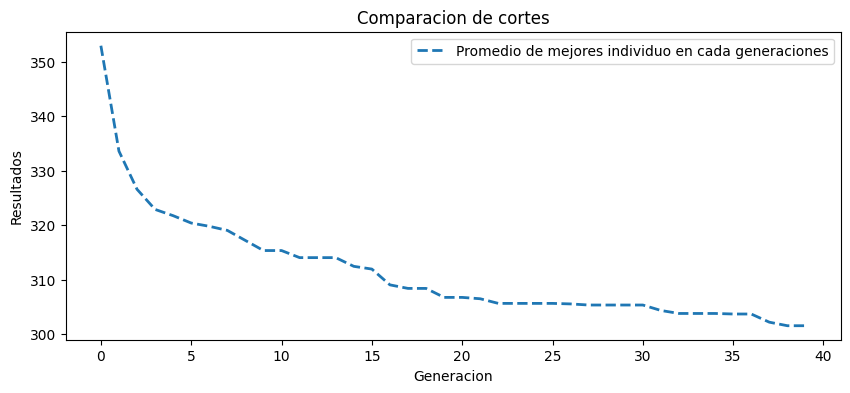

In [509]:
from AlgEvo import AlgEvo
#Se usara una representacion donde el veiculo tiene capacidad para infinitos pasajeros y donde la cantidad de
#Genes a usar es el doble de la cantidad de pasajeros para representar la ubicacion de recojo y dejar pasajeros
#se realizara un ajuste para que cada pasajero sea recogido antes de ser llevado a su destino
def TransformarGenes(Xi):
      PvInicio = list(range(NPASAJEROS))
      PvFin = []
      Nv = []
      for c in Xi:
            Pv = PvInicio + PvFin
            i_ajustado = c % len(Pv)
            PVi_ajustado = Pv[i_ajustado]
            Nv.append(PVi_ajustado)
            if PVi_ajustado < NPASAJEROS: #si se trata de un pasajero
                  PvInicio.remove(PVi_ajustado) #sacarlo de los posibles pasajeros
                  PvFin.append(PVi_ajustado + NPASAJEROS) #Agregarlo a los posibles destinos
            else:
                  PvFin.remove(PVi_ajustado) #pasajero a sido llevado a su destino
      #Ahora Nv contiene una ruta valida   
      return Nv
def F(X):
      res = []
      #print("--------------------------------------------------")
      for Xi in X.T:
            Nv = TransformarGenes(Xi)
            distancia = 0
            for i_tag in range(len(Nv) - 1):
                  tag = Nv[i_tag]
                  p_tag = Nv[i_tag + 1]
                  
                  tag = C.pasajeros[tag % NPASAJEROS].Tag_inicio if tag < NPASAJEROS else C.pasajeros[tag % NPASAJEROS].Tag_final
                  p_tag = C.pasajeros[p_tag % NPASAJEROS].Tag_inicio if p_tag < NPASAJEROS else C.pasajeros[p_tag % NPASAJEROS].Tag_final               
                  
                  distancia += C.Mdistancias[tag][p_tag].distancia
            #print(f"Ruta {[  f"{"S" if i < NPASAJEROS else "D"}{i%NPASAJEROS}"   for i in Nv]} ---> {distancia}")
            res.append(distancia)
      return np.array(res)
AlgEvo.lst_res = []
AlgEvo.MUTATION_RATE = 0.3
AlgEvo.N_GENES = NPASAJEROS * 2
AlgEvo.DNA_SIZE = 6
AlgEvo.X_BOUND = [0, 2 * NPASAJEROS - 1]
#print(f"Inicios: {list(range(NPASAJEROS))} Destinos: {list(range(NPASAJEROS, 2 * NPASAJEROS))}")
#print(AlgEvo.POP)
#print(AlgEvo.GrayToDec(AlgEvo.POP))
AlgEvo.F = F
AlgEvo.N_GENERATIONS = 40
AlgEvo.PADRES = True #Los dos mejores padres sobreviven en la siguiente generacion
resultados = AlgEvo.IterarGraficar()


In [527]:
print(f"Mejor resultado original = {AlgEvo.GrayGenToDec(resultados[0])}")
tags = np.array(TransformarGenes(AlgEvo.GrayGenToDec(resultados[0])))
print(f"Mejor resultado transformado = { tags } = { F(np.array([tags]).T ) }")
solucion = np.array([])
for i in range(NPASAJEROS * 2 - 1):
      tag_ini = tags[i]
      tag_fin = tags[i + 1]
      tag_ini = C.pasajeros[tag_ini % NPASAJEROS].Tag_inicio if tag_ini < NPASAJEROS else C.pasajeros[tag_ini % NPASAJEROS].Tag_final
      tag_fin = C.pasajeros[tag_fin % NPASAJEROS].Tag_inicio if tag_fin < NPASAJEROS else C.pasajeros[tag_fin % NPASAJEROS].Tag_final 
      #print(f"{i}: {tag_ini} - {tag_fin} -> {C.Mdistancias[tag_ini][tag_fin].n_tags} con {C.Mdistancias[tag_ini][tag_fin].distancia}")
      if i == NPASAJEROS * 2 - 2:
            solucion = np.concatenate((solucion, C.Mdistancias[tag_ini][tag_fin].n_tags))
      else:
            solucion = np.concatenate((solucion, 
                                       C.Mdistancias[tag_ini][tag_fin].n_tags[:-1]))
solucion = solucion.astype(int)

Mejor resultado original = [14  0 21 13 10  4 22  5 28  6  5  3 12  5  0 10 17  6 20 28  3 17 19  2
  3  6  9  3 17 15]
Mejor resultado transformado = [14  0  7 15 12  5 11  8  1 13 10  6 25 22  2 21 26 23  9  4 20 29 24 16
 17 28  3 27 18 19] = [458]


# Graficando una solucion

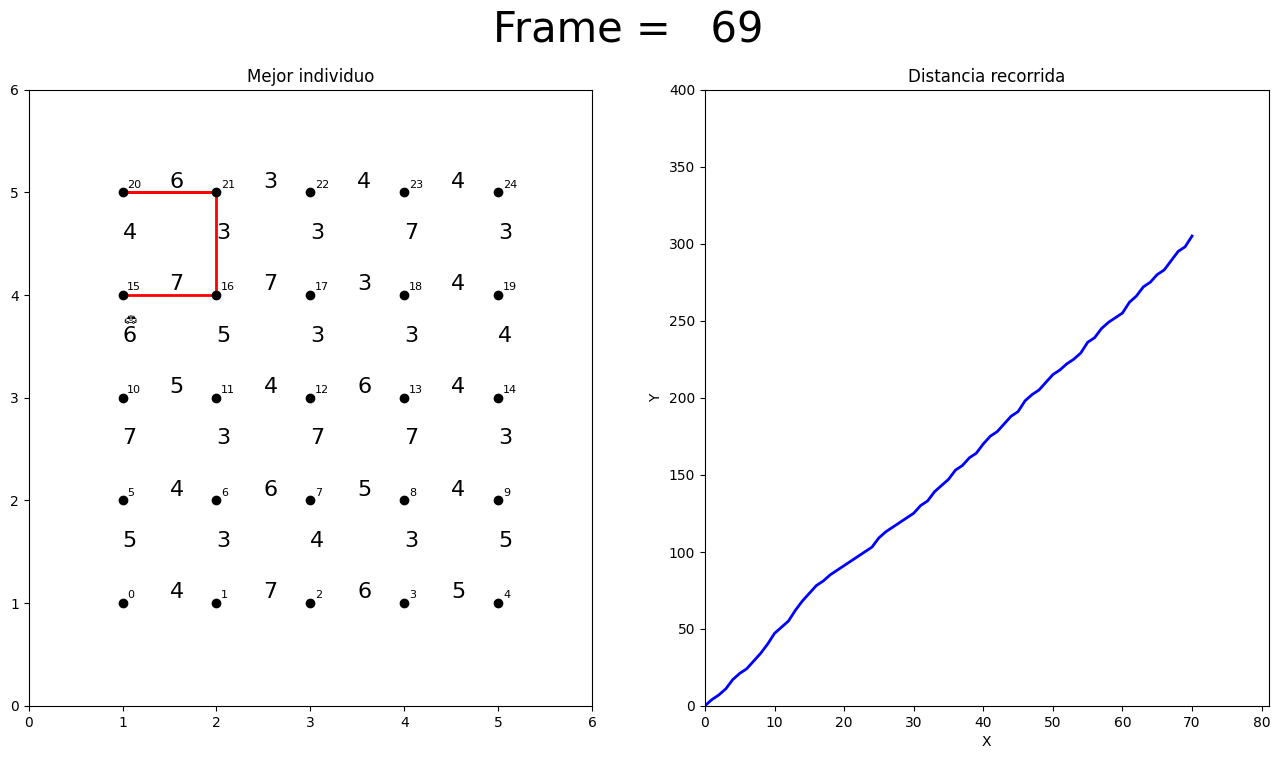

In [529]:
from matplotlib import animation
from IPython.display import HTML

class Graficador_CityCar:
      def __init__(self, c : Ciudad, solucion: list) -> None:
            self.ciudad = c
            self.solucion = solucion
            #Constantes
            self.Pading = 1
            self.GDis = 1
            self.FS = 8
            self.Elevacion = 0.05
      def Reiniciar(self):
            self.LINEAS = [self.ax1.plot([], [], 'r', lw=2) for i in range(len(self.solucion))]
            self.PASAJEROSPN = [self.ax1.text(Nodo.GuiaT_N[i].posicion[0] + self.Pading,
                                              Nodo.GuiaT_N[i].posicion[1] + self.Pading + self.Elevacion* 5,
                                              "", fontsize=self.FS, fontname='Segoe UI Emoji') 
                                for i in range(LADO * LADO)]
            self.TAXI_PPOS = [self.ax1.text(Nodo.GuiaT_N[i].posicion[0] + self.Pading,
                                              Nodo.GuiaT_N[i].posicion[1] + self.Pading - self.Elevacion* 5,
                                              "", fontsize=self.FS, fontname='Segoe UI Emoji') 
                                for i in range(LADO * LADO)]
            self.lstPasajerosAbordo = []
            self.lstPasajerosLlevados = []
            self.recorrido = [0]
            
      def Graficar(self):
            # create a figure and axes
            fig = plt.figure(figsize=(16,8))
            self.ax1 = plt.subplot(1,2,1)   
            self.ax2 = plt.subplot(1,2,2)
            
            self.Reiniciar()
            
            self.ax1.set_title('Mejor individuo')
            self.ax1.set_xlim((0, LADO + self.Pading))            
            self.ax1.set_ylim((0, LADO + self.Pading))
            self.ax1.set_xlabel('')
            self.ax1.set_ylabel('')
            self.GraficarFondo(self.ax1)
            
            self.ax2.set_xlim((0,len(self.solucion) + 10))
            self.ax2.set_ylim((0,400))
            self.ax2.set_xlabel('X')
            self.ax2.set_ylabel('Y')
            self.ax2.set_title('Distancia recorrida')
            
            
            self.txt_title = fig.suptitle('', fontsize=30)
            
            self.line1, = self.ax2.plot([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects
            self.line2, = self.ax2.plot([], [], 'r', lw=2)
            
            anim = animation.FuncAnimation(fig, self.drawframe, frames= len(self.solucion), interval=120, blit=True)
            return HTML(anim.to_html5_video())
      def GraficarFondo(self, ax1):
            for nodo in Nodo.GuiaT_N.values():
                  X = nodo.posicion[0] + self.Pading
                  Y = nodo.posicion[1] + self.Pading
                  ax1.plot(X, Y, 'o', c = "black")
                  ax1.text(X + self.Elevacion, Y + self.Elevacion, nodo.tag, fontsize = self.FS)
                  for nodo_vecino in nodo.vecinos:
                        if nodo_vecino.tag > nodo.tag: continue
                        Xv = nodo_vecino.posicion[0] + self.Pading
                        Yv = nodo_vecino.posicion[1] + self.Pading
                        d = Nodo.GuiaTT_D[(nodo.tag, nodo_vecino.tag)]
                        ax1.text(X/2 + Xv/2, Y/2 + Yv/2 + self.Elevacion, d, fontsize= 3*2 * self.FS/ 3)
                       
                        
      def drawframe(self,n):
            N = n - 1
            nodo_actual = Nodo.GuiaT_N[self.solucion[N + 1]]
            for i in range(len(self.TAXI_PPOS)):
                        self.TAXI_PPOS[i].set_text("🚕" if nodo_actual.tag == i else "") 
            pasajeros_suben = [p for p in self.ciudad.pasajeros if p.Tag_inicio == nodo_actual.tag]      
            self.lstPasajerosAbordo += pasajeros_suben
            
            pasajeros_bajan = [p for p in self.lstPasajerosAbordo if p.Tag_final == nodo_actual.tag]      
            self.lstPasajerosLlevados += pasajeros_bajan
            self.lstPasajerosAbordo = [p for p in self.lstPasajerosAbordo if p.Tag_final != nodo_actual.tag]                 
                  
            if N != -1: 
                  linea = self.LINEAS[N][0]
                  nodo_anterior = Nodo.GuiaT_N[self.solucion[N]]
                  Xl = [nodo_anterior.posicion[0] + self.Pading, nodo_actual.posicion[0] + self.Pading]
                  Yl = [nodo_anterior.posicion[1] + self.Pading, nodo_actual.posicion[1] + self.Pading]
                  linea.set_data(Xl, Yl)
                  self.txt_title.set_text('Frame = {0:4d}'.format(N))
                  self.recorrido.append(self.recorrido[-1] + Nodo.GuiaTT_D[(nodo_actual.tag,nodo_anterior.tag)])
                  
            if(N - 4 >= 0):
                  linea = self.LINEAS[N - 4][0]
                  linea.set_data([], [])
                  
            X,Y,S = self.ciudad.getPasajerosTag([p.tag for p in self.lstPasajerosLlevados], [p.tag for p in self.lstPasajerosAbordo])
            for i in range(len(self.PASAJEROSPN)):
                        self.PASAJEROSPN[i].set_text(S[i])      
            
            self.line1.set_data(range(len(self.recorrido)), self.recorrido)
            
            return (self.line1,self.line2)
      
Gcity = Graficador_CityCar(C, solucion)      
Gcity.Graficar()